# **PARAMETER ID**

>*Manan Luthra*
>(*1219336040*)
1. Buckling Test
2. Mass and Inertia Properties 
3. Setup and Analysis of Damping setup using Tracker Physics Software 


1. BUCKLING TEST 
> This experiment aimed at determining whether our system buckles due to axial load. When assessing and designing structures, there are usually two main concerns: (1) the structure's ability to support a given load without experiencing excessive stress, and (2) the structure's ability to support a given load without incurring unacceptable deformation. In this experiment, the element to be tested is a single layer (laser cut) tesselation of the prototype. A setup was created using LEGOs which allowed me to put load on the leg and perform the test as shown in the image below. 


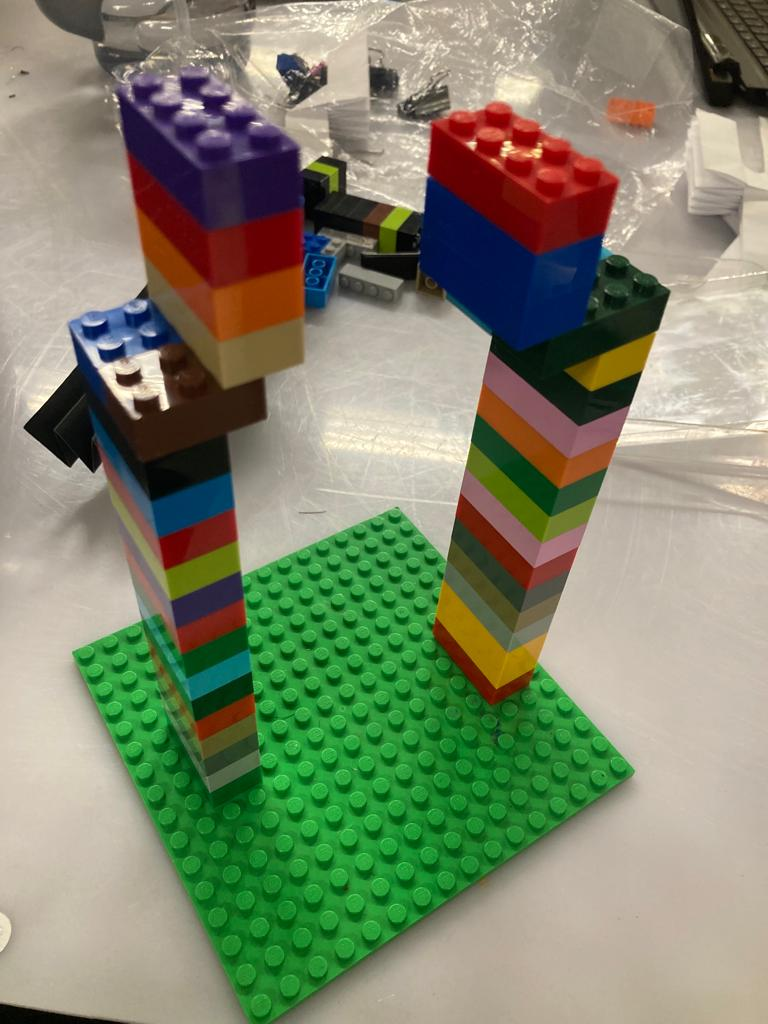


Here is the top base for the framed system which works like an axial slider: 


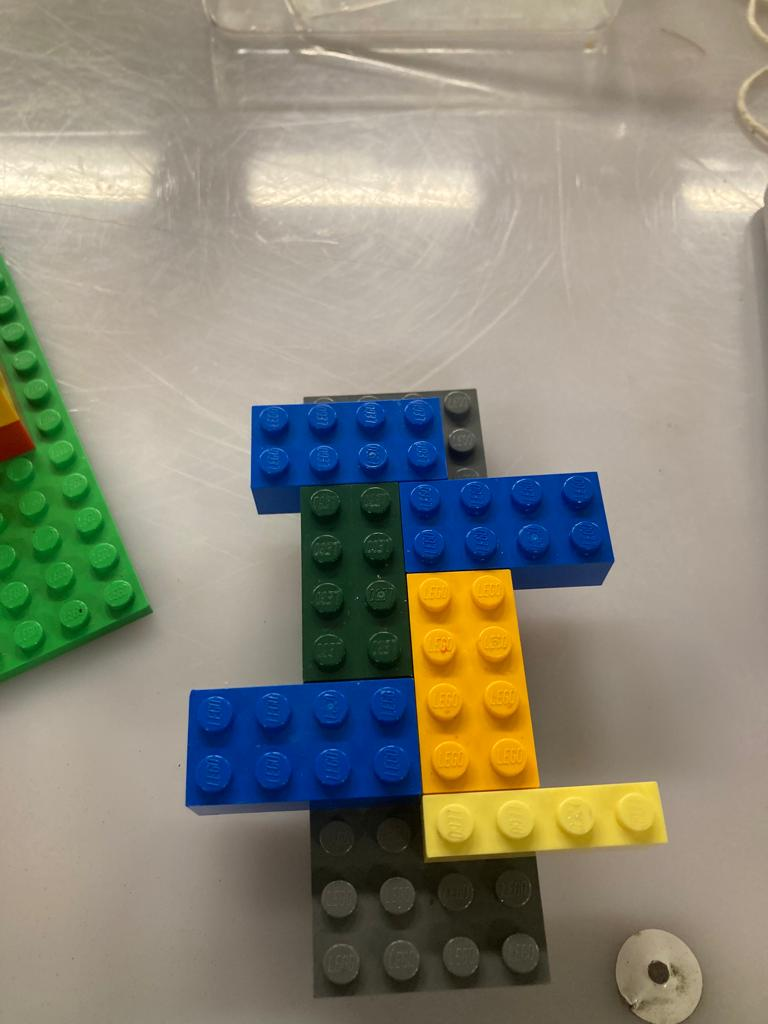

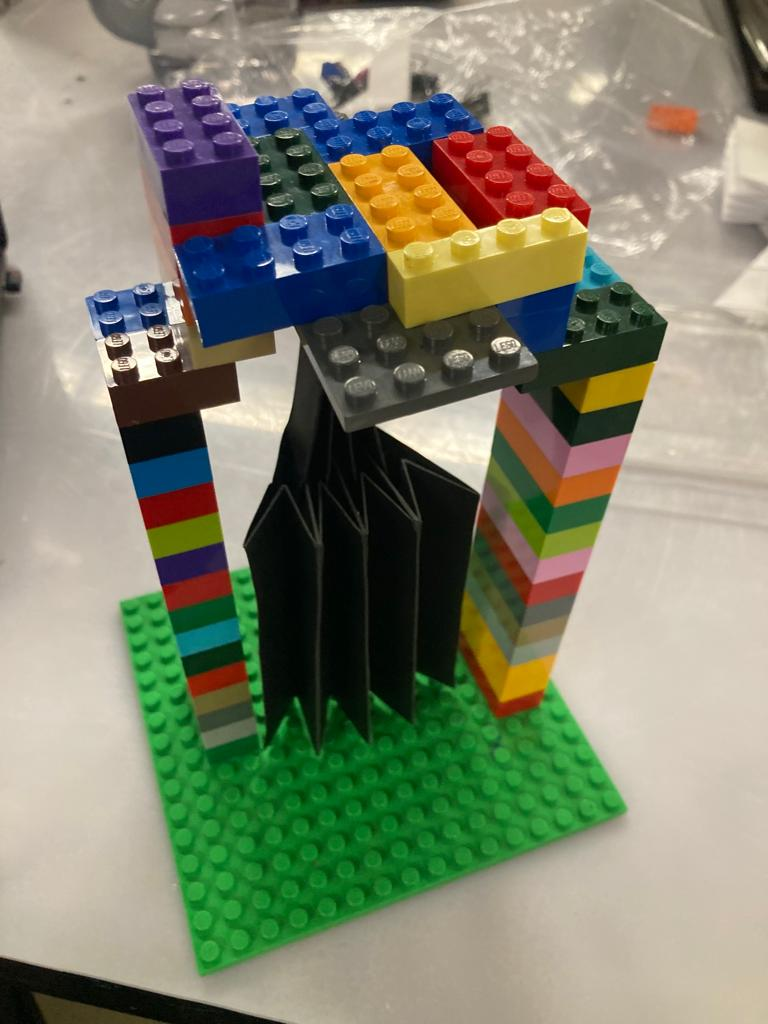

The dimensions of the laser cut leg: 80.6mm x 22.5mm, thickness 3mm.  On adding weight to the top base plate, I was able to deduce the maximum weight beyond which the leg buckles. The maximum buckling weight came out to be 423.1g (Refer to the video attached in drive)

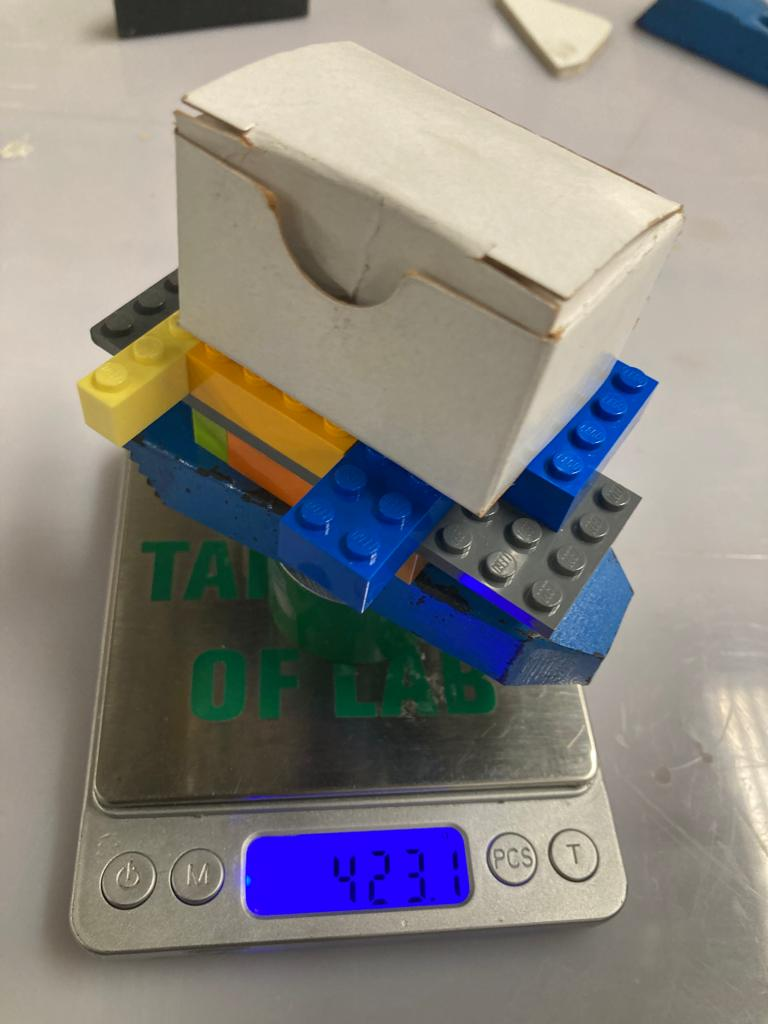

2. Mass and Inertia Properties


> This was a colaborative effort amongst the team members. My role was to take the computed mass and inertia values and modify our dynamics code to reach optimization. I considered experimenting on a single leg rather than the complete system and modified the values to obtain the following results:



In [ ]:
!pip install pynamics
%matplotlib inline
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
from pynamics.constraint import AccelerationConstraint
import pynamics.integration
import numpy
import sympy
import matplotlib.pyplot as plt
plt.ion()
from math import pi

     |████████████████████████████████| 87 kB 3.9 MB/s 


In [ ]:
system=System()
pynamics.set_system(__name__,system)

I considered a single leg instead of four and updated the values of mass and moment of inertia as computed theortically. 

In [ ]:
#lenghts in m
lB = Constant(.15,'lB',system)
lC = Constant(0.06604,'lC',system)
lD = Constant(0.0889,'lD',system)


#masses in kg
mB = Constant(.5,'mB',system)
mC = Constant(0.0028799999999999997,'mC',system)
mD = Constant(0.002216,'mD',system)


g = Constant(9.81,'g',system)     #Gravity 
b = Constant(1e-4,'b',system)
k = Constant(1e-2,'k',system)
kEndStop = Constant(1e1,'kEndStop',system)
bEndStop = Constant(1e-1,'bEndStop',system)
preload1 = Constant(-80*pi/180,'preload1',system)
preload2 = Constant(-15*pi/180,'preload2',system)

#end stop limits
limit = Constant(-(-0*pi/180),'limit',system)


#Inertial values that describe the dyatics/inertia of the rigid bodies about x, y and z axes 
Ixx_B = Constant(1e-1,'Ixx_B',system)
Iyy_B = Constant(1e-1,'Iyy_B',system)
Izz_B = Constant(1e-1,'Izz_B',system)
Ixx_C = Constant(1e-2,'Ixx_C',system)
Iyy_C = Constant(1e-2,'Iyy_C',system)
Izz_C = Constant(5.420568769248424e-07,'Izz_C',system)
Ixx_D = Constant(1e-2,'Ixx_D',system)
Iyy_D = Constant(1e-2,'Iyy_D',system)
Izz_D = Constant(9.437043491466668e-08,'Izz_D',system)


In [ ]:
#3 state variables:
qC,qC_d,qC_dd = Differentiable('qC',system)
qD,qD_d,qD_dd = Differentiable('qD',system)


# state variables for body position and rotation
Ax,Ax_d,Ax_dd = Differentiable('Ax',system)
Ay,Ay_d,Ay_dd = Differentiable('Ay',system)
Aq,Aq_d,Aq_dd = Differentiable('Aq',system)

In [ ]:
initialvalues = {}
initialvalues[Aq]=0*pi/180
initialvalues[Aq_d]=0*pi/180
initialvalues[Ax]=0
initialvalues[Ax_d]=0
initialvalues[Ay]=0.1
initialvalues[Ay_d]=0

initialvalues[qC]=-60*pi/180
initialvalues[qC_d]=0*pi/180
initialvalues[qD]=-15*pi/180
initialvalues[qD_d]=0*pi/180



In [ ]:
statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

I defined the reference frames of the system as follows:

In [ ]:
N = Frame('N',system)
A = Frame('A',system)

C = Frame('C',system)
D = Frame('D',system)



In [ ]:
system.set_newtonian(N)
A.rotate_fixed_axis(N,[0,0,1],Aq,system)

In [ ]:
#legs attached to the body
C.rotate_fixed_axis(A,[0,0,1],qC,system)

#legs attacheced to legs
D.rotate_fixed_axis(C,[0,0,1],qD,system)

In [ ]:
pNO=0*N.x
#body
pNA = Ax*N.x + Ay*N.y
pAB = pNA + lB*A.x
#legs
pBC = pAB + lC*C.x
pCD = pBC + lD*D.x


I computed the center of mass of the system as follows:

In [ ]:
pAcm=pNA+lB/2*A.x  
pCcm = pBC - lC/2*C.x
pDcm = pCD - lD/2*D.x

In [ ]:
#Angular velocity
wNA = N.get_w_to(A) 

wAC = A.get_w_to(C)

wCD = C.get_w_to(D)

In [ ]:
IA = Dyadic.build(A,Ixx_B,Iyy_B,Izz_B)
IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)
ID = Dyadic.build(D,Ixx_D,Iyy_D,Izz_D)


BodyA = Body('BodyA',A,pAcm,mB,IA,system)
BodyC = Body('BodyC',C,pCcm,mC,IC,system)
BodyD = Body('BodyD',D,pDcm,mD,ID,system)

In [ ]:
# Damper forces
system.addforce(-b*wAC,wAC)
system.addforce(-b*wCD,wCD)


In [ ]:
#Spring forces
system.add_spring_force1(k,(qC-preload1)*A.z,wAC)
system.add_spring_force1(k,(qD-preload2)*C.z,wCD)


(<pynamics.force.Force at 0x7fb4f7ffec10>,
 <pynamics.spring.Spring at 0x7fb4f7ffe390>)

In [ ]:
#end Stops
system.add_spring_force1(kEndStop,((abs(qD+limit)+qD+limit)/(2*(qD+limit)))*(qD+limit)*C.z,wCD)

#end Stop Damping
system.addforce(-bEndStop*((abs(qD+limit)+qD+limit)/(2*(qD+limit)))*wCD,wCD)

In [ ]:
#constraning AB not to fall

eq = []
eq.append(.1*N.y - pNA)
eq.append(.1*N.y+.15*N.x - pAB)

eq_scalar = []
eq_scalar.append(eq[0].dot(N.x))
eq_scalar.append(eq[0].dot(N.y))
#eq_scalar.append(eq[1].dot(N.x))
eq_scalar.append(eq[1].dot(N.y))

eq_d = [item.time_derivative() for item in eq]
eq_dd = [item.time_derivative() for item in eq_d]
eq_dd_scalar = []
eq_dd_scalar.append(eq_dd[0].dot(N.x))
eq_dd_scalar.append(eq_dd[0].dot(N.y))
#eq_dd_scalar.append(eq_dd[1].dot(N.x))
eq_dd_scalar.append(eq_dd[1].dot(N.y))

system.add_constraint(AccelerationConstraint(eq_dd_scalar))

In [ ]:
system.addforcegravity(-g*N.y)

In [ ]:
f,ma = system.getdynamics()

2022-04-13 02:35:27,377 - pynamics.system - INFO - getting dynamic equations


In [ ]:
func1,lambda1 = system.state_space_post_invert(f,ma,return_lambda = True)


2022-04-13 02:35:28,292 - pynamics.system - INFO - solving a = f/m and creating function
2022-04-13 02:35:28,339 - pynamics.system - INFO - substituting constrained in Ma-f.
2022-04-13 02:35:28,545 - pynamics.system - INFO - done solving a = f/m and creating function
2022-04-13 02:35:28,546 - pynamics.system - INFO - calculating function for lambdas


In [ ]:
tol = 1e-5

In [ ]:
tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

In [ ]:
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))


2022-04-13 02:35:28,598 - pynamics.integration - INFO - beginning integration
2022-04-13 02:35:28,601 - pynamics.system - INFO - integration at time 0000.00
2022-04-13 02:35:29,317 - pynamics.system - INFO - integration at time 0003.97
2022-04-13 02:35:29,881 - pynamics.integration - INFO - finished integration


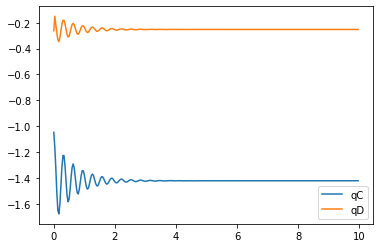

In [ ]:
plt.figure()
artists = plt.plot(t,states[:,:2])
plt.legend(artists,['qC','qD'])

2022-04-13 02:35:30,207 - pynamics.output - INFO - calculating outputs
2022-04-13 02:35:30,245 - pynamics.output - INFO - done calculating outputs


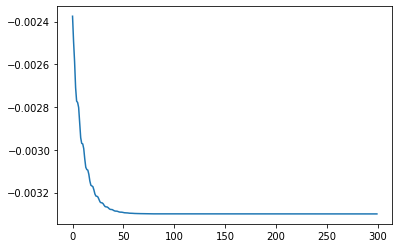

In [ ]:
KE = system.get_KE()
PE = system.getPEGravity(pNA) - system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states,t)
energy_output.plot_time()

2022-04-13 02:38:31,041 - pynamics.output - INFO - calculating outputs
2022-04-13 02:38:31,089 - pynamics.output - INFO - done calculating outputs


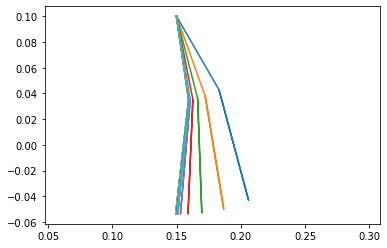

In [ ]:
points = [pAB,pBC,pCD,pBC]
points_output = PointsOutput(points,system)
y = points_output.calc(states,t)
points_output.plot_time(10)

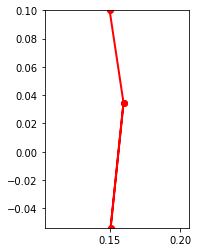

In [ ]:
points_output.animate(fps = fps,movie_name = 'triple_pendulum.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')

Here, we obtain the dynamics output of a single leg under constraint and optimal values of mass and moment of inertia. 

In [ ]:
from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())

This output pretty much resembles with the damping test performed ahead. 

3. Setup and Analysis of Damping setup using Tracker Physics Software 


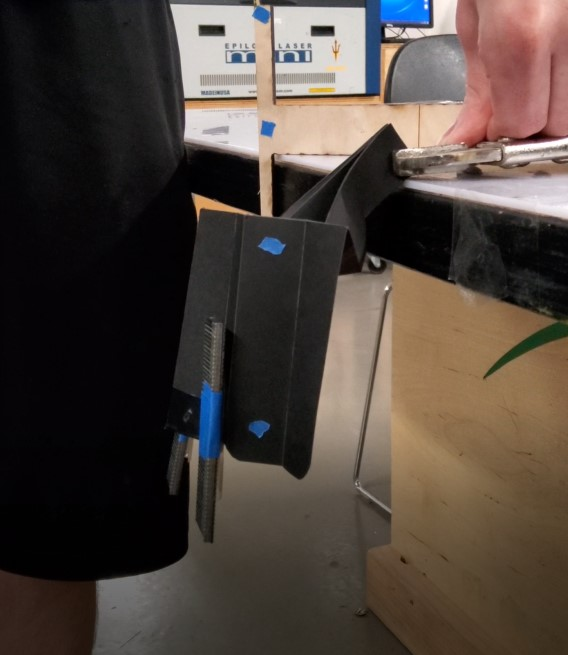

The above pictures show the experimental setup used in this test. Vice grips were used to hold the prototype leg. Two Weights of 45g each were attached to the bottom of the leg to promote damping. Blue markers were attached at mulitple positions for high visibility. Two reference points were taken at the back of the setup. A video was taken in slo motion and was evaluated using the Tracker (Physics) software. 

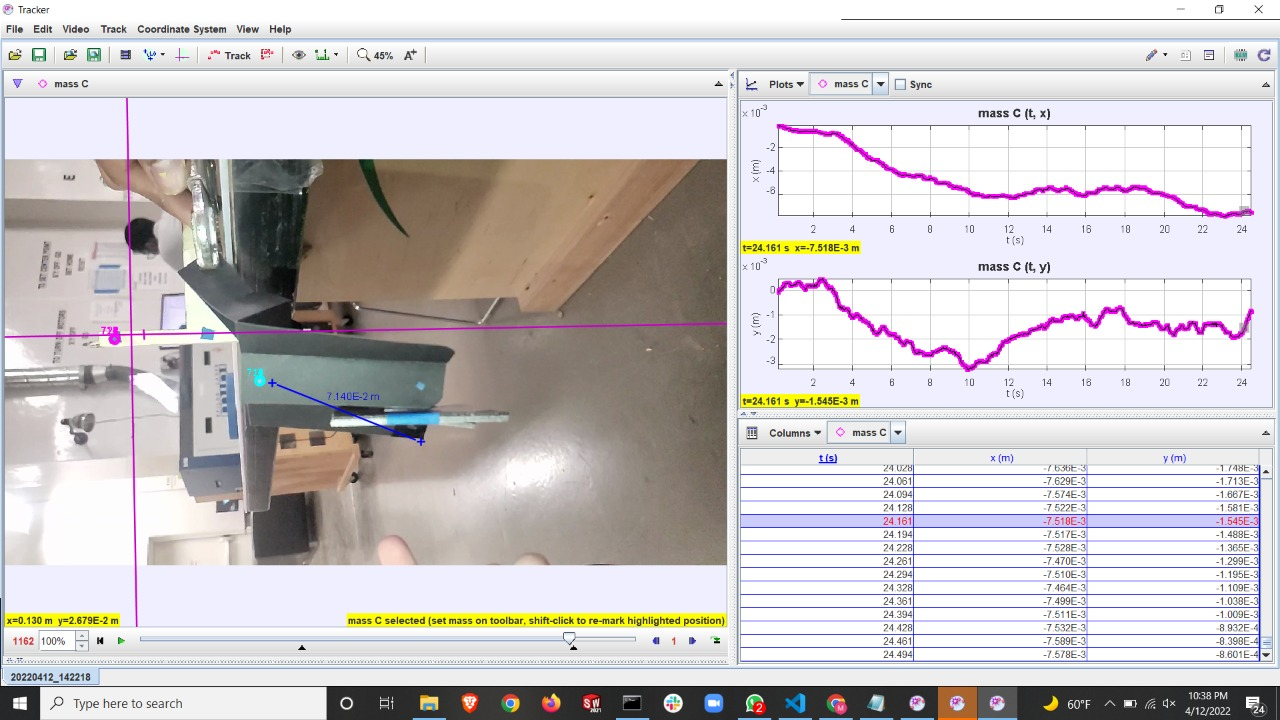

I began by selecting the frame length of the video to be evaluated by placing the black markers in position. Next, I added the coordinate axis and fit it according to the reference frame. I added a calibration stick to the markers on the prototype leg. This allowed me to autotrack the damping oscillations of the leg as a single mass. The output waveforms and values are shown as above. 

# **Discussion**


What could you have done better in your experiment design and setup?
> For Buckling test, I believe I could have used wooden L brackets as a setup instead of LEGOs. This would have allowed me to better calculate the critical force on the system in a Fixed-Pin configuration. 

Discuss your rationale for the model you selected. Describe any assumptions or simplificatons this model makes. Include external references used in selecting or understanding your model.
> For the Damping setup, I assumed joints to be the damping points. Due to the time constraints, I believe the setup does justice to my evaluation and testing. 

Justify the method you selected (least squares, nonlinear least squares, scipy.optimize.minimize(), Evolutionary algorithm, etc. ) for fitting experimental data to the model, as well as the specific algorithm used.
>For fitting and comparing experimental data to the model, I used the pynamics and numpy libraries in python. 

How well does your data fit the model you selected? Provide a numerical value as well as a qualitative analysis, using your figure to explain.
> Unfortunatley, at this point I can not deduce a numerical analysis. I plan to perform th Finite Element Analysis of the model soon which would allow me to compare and assess the experimented and modeled data. 

What are the limits of your model, within which you are confident of a good fit? Do you expect your system to operate outside of those limits?
> For the Buckling test, I believe that a mass heavier that 423.1g would buckle a single leg. However, if we consider the whole system and involve constraints, I believe the model could take up a load of approx. 1.5Kgs which is a feasible option for the project. 

Google Drive Link for Videos and Data: https://drive.google.com/drive/folders/1D1277DdDyKaccWm6PckYsqXZV--CnjyS?usp=sharing